# Compute LANDSAT indices
Author: Helyne Adamson

### This is a mini tutorial on how to derive some standard (and not so standard) satellite indices:
- NDVI
- MNDWI
- NDBI
- Impervious 

> NOTE: You probably don't need to worry about masking water per image or impervious surface derivation for our Ouagadougou study :) you also don't need to download the old landsat data (Landsat 5-7), since we're working with more recent time periods.


### **Pipeline Overview**

**1. Load & Filter**

- Merge Landsat collections (5/7/8/9)
- Filter by bounds, date range, and cloud cover (<20%)

**2. Per-Image Processing (applied to each image via .map())**

- Cloud/shadow mask (pixel-level, using QA band)
- Harmonize band names & scale DN → reflectance
- Compute spectral indices (NDVI, MNDWI, NDBI)
- Mask water pixels (only needed here for impervious surface calculation)

**3. Temporal Compositing**

- Create annual median composite from all processed images

**4. Derived Products (computed on the composite)**

- Impervious surface fraction (dimidiate pixel model with fixed NDVI reference values)
- Apply a composite water mask to ensure consistency across output bands

**5. Export**

- Generate both raw (includes water) and masked (water = NoData) versions
- Reproject to UTM

# Import libraries

In [66]:
import ee
import geemap
import geemap.colormaps as cm
import matplotlib.pyplot as plt
import os
import rasterio


# Initialize GEE

In [ ]:
# Initialize the Earth Engine module.
ee.Authenticate()   # can be commented out if already authenticated
ee.Initialize()

# Define output dir and region of interest

In [70]:
# Create local data directory
data_dir = "/home/jovyan/shared-public/poseidon_heatwaves/data/"  
data_dir = "/Users/helyne/code/climatematch/poseidon_heatwaves/data/"  
landsat_dir = os.path.join(data_dir, "landsat_shanghai")
os.makedirs(landsat_dir, exist_ok=True)

print(f"Data will be saved to: {landsat_dir}")

Data will be saved to: /Users/helyne/code/climatematch/poseidon_heatwaves/data/landsat_shanghai


In [71]:
# Define our study area - Shanghai, China
shanghai_bounds = [120.8, 30.6, 122.2, 31.9] # [West, South, East, North]
shanghai = ee.Geometry.Rectangle(shanghai_bounds)

# Data Preprocessing Functions

In [ ]:
# Preprocessing functions

def mask_clouds(image):
    """
    Remove clouds and cloud shadows from Landsat imagery.
    
    Cloud masking is essential because:
    - Clouds block our view of the ground surface
    - They have very different temperatures and reflectance
    - Without masking, clouds would be classified as bright urban areas
    - This would mess up our impervious surface mapping
    
    Args:
        image: Landsat image with QA_PIXEL band
        
    Returns:
        Image with cloud and shadow pixels masked
    """
    print("🌤️ Removing clouds and shadows...")
    
    # Get the quality assessment band (QA_PIXEL)
    # This band contains bit-encoded quality information for each pixel
    qa = image.select('QA_PIXEL')
        
    # Extract cloud and cloud shadow bits using bitwise operations (1 = bit set, 0 = bit clear)
    # `bitwiseAnd(1 << N)` isolates the Nth bit
    cloud_bit = 1 << 3        # Binary: 1000 (bit 3)
    shadow_bit = 1 << 4       # Binary: 10000 (bit 4)
    snow_ice_bit = 1 << 5     # Binary: 100000 (bit 5)
    
    # Create masks: True = clear pixel, False = cloudy/shadow pixel
    # `.eq(0)` checks if the bit is NOT SET (condition absent)
    cloud_mask = qa.bitwiseAnd(cloud_bit).eq(0)    # 0 = no cloud
    shadow_mask = qa.bitwiseAnd(shadow_bit).eq(0)   # 0 = no cloud shadow
    snow_ice_mask = qa.bitwiseAnd(snow_ice_bit).eq(0)   # 0 = no snow/ice
    
    # Combine masks: keep only pixels that are both cloud-free AND shadow-free
    clear_mask = cloud_mask.And(shadow_mask).And(snow_ice_mask)
    
    # Apply the mask to hide cloudy/shadow pixels
    return image.updateMask(clear_mask)

def harmonize(image):
    """
    Harmonize band names and scaling across different Landsat satellites.
    
    Different Landsat satellites (5/7 vs 8/9) have different band numbering
    schemes. This function standardizes them to common names and applies
    proper scaling factors.
    
    Args:
        image: Raw Landsat image
        
    Returns:
        Harmonized image with consistent band names and scaling
    """
    print("🔧 Harmonizing different satellite sensors...")
        
    # Define band mappings for each satellite
    # L8 has different band numbers than L5/7
    landsat89_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
    landsat57_bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
    common_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

    # Identify which satellite took this image
    spacecraft = ee.String(image.get('SPACECRAFT_ID'))
    is_oli = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(spacecraft)
    
    # Select appropriate bands
    harmonized = ee.Algorithms.If(
        is_oli,
        image.select(landsat89_bands, common_names),  # select landsat8/9 band mapping if true
        image.select(landsat57_bands, common_names)
    )
    
    # Apply appropriate Collection 2 scaling: DN * 0.0000275 - 0.2
    scaled = ee.Image(harmonized).multiply(0.0000275).add(-0.2)

    # Clamp to valid reflectance range (removes artifacts)
    scaled = scaled.clamp(0, 1)

    return scaled.copyProperties(image, ['system:time_start'])  # copy time info

def compute_spectral_indices(image):
    """
    Add spectral indices useful for land cover classification.
        
    WHAT ARE SPECTRAL INDICES?
    - Mathematical combinations of different wavelengths (bands)
    - Each index highlights different surface materials (e.g. vegetation or water)
        
    1. NDVI (Normalized Difference Vegetation Index)
        - Formula: (NIR - Red) / (NIR + Red)
        - Plants reflect lots of near-infrared but absorb red light
        - Result: High NDVI = lots of vegetation, Low NDVI = little vegetation
    
    2. MNDWI (Modified Normalized Difference Water Index)
        - Formula: (Green - SWIR) / (Green + SWIR)
        - Water absorbs shortwave infrared but reflects green light
        - Result: High MNDWI = water bodies, Low MNDWI = land surfaces, vegetation, or soil
    
    3. NDBI (Normalized Difference Built-up Index) - for comparison
        - Formula: (SWIR - NIR) / (SWIR + NIR)
        - Buildings/concrete reflect more shortwave infrared than vegetation
        - Result: High NDBI = urban areas, Low NDBI = natural areas
        - Note: This is a modern validation method not in our reference studies. 
                We can compare this with the NDVI-based method for validation.
                
    Args:
        image: Harmonized Landsat image with standard band names
        
    Returns:
        Image with additional spectral index bands
    """
    print(f"🧮 Calculating spectral indices...")
    
    ndvi = image.normalizedDifference(['nir', 'red']).rename('NDVI')
    mndwi = image.normalizedDifference(['green', 'swir1']).rename('MNDWI')
    ndbi = image.normalizedDifference(['swir1', 'nir']).rename('NDBI')
    
    return image.addBands([ndvi, mndwi, ndbi])


def mask_water(image):
    """
    Mask out water pixels per-image before computing impervious surfaces or median annual composite.
    
    Water has very negative NDVI (~-0.3 to -0.5).
    
    By masking water early, we ensure:
    1. Any NDVI statistics reflect only land surfaces
    2. Vegetation fraction calculations are meaningful
    3. Water doesn't contaminate impervious surface estimates
    """
    mndwi = image.select('MNDWI')
    
    # Water has high MNDWI (> ~0.1 to 0.3)
    # Using 0.1 is conservative - catches most water including turbid water
    water_mask = mndwi.lt(0.3)  # Select pixels less than 0.3 (i.e., non-water)
    
    return image.updateMask(water_mask)


def compute_impervious_surfaces(image):
    """
    Calculate impervious surfaces
    
    WHAT ARE IMPERVIOUS SURFACES?
    - Surfaces that don't absorb water: concrete, asphalt, rooftops, parking lots
    - Key indicator of urbanization and development intensity
    - Relevant for urban heat island studies (e.g.concrete heats up more than grass)
    
    Args:
        image: Harmonized Landsat image with standard band names and computed spectral indices
        
    Returns:
        Image with additional computed measure: impervious surface (IS)
    """
    print("🏙️  Mapping impervious surfaces...")

    # Inverse vegetation (Dimidiate Pixel Model) (after Wang et al. 2017)
    # Concept: Where there's lots of plants, there's little concrete
    
    # 1. Get our calculated indices
    ndvi = image.select('NDVI')

    # 2. Calculate min/max NDVI (for vegetation coverage calculation)
    # SIMPLE LITERATURE-BASED FIXED VALUE APPROACH
    # These represent "pure" endmembers and stay constant across all years
    ndvi_min = ee.Number(0.05) # NDVI of bare soil/impervious surface (0% vegetation)
    ndvi_max = ee.Number(0.75) # NDVI of dense vegetation (100% vegetation)

    # 3. Compute vegetation coverage (continuous 0-1) using dimidiate pixel model
    # Vc = (NDVI - NDVImin) / (NDVImax - NDVImin)
    vc = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).clamp(0, 1)
    
    # 4. Calculate impervious surface (Wang et al. formula)
    # Impervious surface = 1 - vegetation coverage
    impervious_surface = ee.Image(1).subtract(vc).rename('IS')

    return image.addBands(impervious_surface)

In [140]:
# Final pipeline
# Putting it all together to create an annual composite image for a given year
def annual_image(year):
    """
    Create annual composite image from all available Landsat data.

    Processing pipeline:
    1. Load & filter: Merge Landsat 5/7/8/9, filter by bounds, date, cloud cover (<20%)
    2. Per-image processing (two parallel branches):
       a) Masked: cloud mask → harmonize/scale → indices → water mask
       b) Unmasked: cloud mask → harmonize/scale → indices
    3. Create median composites from both branches
    4. Compute impervious surface on masked composite (fixed NDVI reference values)
    5. Derive water mask from unmasked MNDWI (threshold 0.3)
    6. Generate output bands: raw (with water) and masked (water = NoData)
    7. Reproject to UTM (EPSG:32651, 30m)

    Args:
        year: Year for which to create the composite (int)
        
    Returns:
        Annual median composite with NDVI, MNDWI, NDBI, and impervious surface bands
    """
    print(f"\n📡 Collecting Landsat data for {year}")

    # Collect all available Landsat data for the year
    landsat_collection = (
                    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
                   .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'))
                   .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'))
                   .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_L2'))
                   .filterBounds(shanghai)
                   .filterDate(f'{year}-01-01', f'{year}-12-31')
                   .filter(ee.Filter.lt('CLOUD_COVER', 20))  # Only images with <20% clouds
                   )

    # Process each image WITH water mask (for impervious surface calculation)
    # cloud mask → scale → indices → water mask
    processed_masked = (landsat_collection
                        .map(mask_clouds)
                        .map(harmonize)
                        .map(compute_spectral_indices)
                        .map(mask_water))
    
    # Process each image WITHOUT water mask (for raw indices)
    # cloud mask → scale → indices
    processed_unmasked = (landsat_collection
                        .map(mask_clouds)
                        .map(harmonize)
                        .map(compute_spectral_indices))
    
    # Create annual median composites
    median_masked = processed_masked.median().clip(shanghai)
    median_unmasked = processed_unmasked.median().clip(shanghai)

    # Compute impervious surfaces on the masked composite
    median_masked = compute_impervious_surfaces(median_masked)
    impervious = median_masked.select('IS')

    # Create water mask from unmasked median MNDWI
    water_mask = median_unmasked.select('MNDWI').lt(0.3)
    
    # Extract bands with different masking levels:
    # 1. RAW (includes water pixels)
    ndvi_raw = median_unmasked.select('NDVI')
    mndwi_raw = median_unmasked.select('MNDWI')
    ndbi_raw = median_unmasked.select('NDBI')
    
    # 2. MASKED (water pixels removed)
    ndvi_masked = median_unmasked.select('NDVI').updateMask(water_mask).rename('NDVI_masked')
    ndbi_masked = median_unmasked.select('NDBI').updateMask(water_mask).rename('NDBI_masked')
    impervious_masked = median_masked.select('IS').updateMask(water_mask).rename('IS_masked')
    
    # Combine all bands
    composite_image = (ee.Image.cat([
        ndvi_raw,
        ndvi_masked,
        ndbi_raw,
        ndbi_masked,
        impervious,
        impervious_masked,
        mndwi_raw,  # Keep raw - useful for water identification
    ]))

    # Add year as property
    annual_image = composite_image.set('year', year)
    
    # Reproject to UTM and scale
    # For Shanghai (≈ 31°N, 121°E) the usual choice is UTM zone 51 N, EPSG 32651
    # 30 m Landsat native resolution
    annual_image = annual_image.reproject(crs='EPSG:32651', scale=30)

    return annual_image


# Process data and inspect

In [ ]:
# Create a dataset annual composites
start_year = 2023
end_year = 2025

shanghai_annual_composites = []

for yr in range(start_year, end_year):
    shanghai_annual_composites.append(annual_image(yr))

shanghai_annual_composites


📡 Collecting Landsat data for 2023
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...

📡 Collecting Landsat data for 2024
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different

[<ee.image.Image at 0x125fca210>, <ee.image.Image at 0x125fd9af0>]

In [ ]:
# Check band names
shanghai_annual_composites[0].bandNames().getInfo()

['NDVI', 'NDVI_masked', 'NDBI', 'NDBI_masked', 'IS', 'IS_masked', 'MNDWI']

In [ ]:
# Inspect one band
shanghai_annual_composites[0].select('IS')

# Visualize the results with Geemap

In [ ]:
# Select one image to visualize
img = shanghai_annual_composites[0]

# Use small roi to speed up visualization
center = img.geometry().centroid()  # center point of image
roi = center.buffer(5_000).bounds()    # ~5 km buffer
roi = center.buffer(30_000).bounds()    # ~30 km buffer
# roi = img.geometry()  # Use this to visualize full image

# Select bands to visualize
bands = ["IS_masked", "NDVI_masked", "NDBI_masked"]

# Coarsen for preview (speeds things up if the image is huge/high-res)
preview_scale = 2000  # in meters, higher = coarser
proj = img.select("IS").projection()
imgp = img.select(bands).clip(roi).reproject(proj, None, preview_scale)

# Create map
map_shang = geemap.Map()
map_shang.centerObject(roi, 9)

vis_palette = {"palette": cm.get_palette('viridis')}  # color palette

# Add layers
map_shang.addLayer(imgp.select("IS_masked"), vis_palette, "IS")
map_shang.addLayer(imgp.select("NDVI_masked"), vis_palette, "NDVI")
map_shang.addLayer(imgp.select("NDBI_masked"), vis_palette, "NDBI")
# Add colorbar
map_shang.add_colorbar(vis_palette, label='Values (0-1)')

map_shang


Map(center=[31.250287505053674, 121.5007185632273], controls=(WidgetControl(options=['position', 'transparent_…

# Visualize the results with rasterio (must download first)

In [ ]:
# Download annual composites directly to local drive (large files, takes a while!)
start_year = 2024
end_year = 2025

for yr in range(start_year, end_year):
    filename = os.path.join(landsat_dir, f'shanghai_{yr}.tif')
    image = annual_image(yr)

    geemap.download_ee_image(
        image,
        filename=filename,
        region=shanghai)


# Select year to plot
yr = 2024
filename_a = os.path.join(landsat_dir, f"shanghai_{yr}.tif")


📡 Collecting Landsat data for 2024
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


Consider adjusting `region`, `scale` and/or `dtype` to reduce the shanghai_2024.tif download size (raw: 1.23 GB).


shanghai_2024.tif: |          | 0.00/1.23G (raw) [  0.0%] in 00:00 (eta:     ?)

### Plot single band

Year: 2024, # bands: 7
Size: 4511 x 4865, projection: EPSG:32651
Bands: ('NDVI', 'NDVI_masked', 'NDBI', 'NDBI_masked', 'IS', 'IS_masked', 'MNDWI')


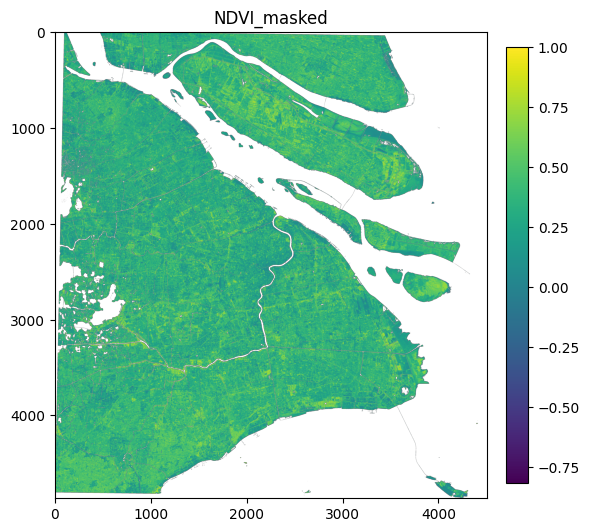

In [ ]:
# Open the file and read all bands
with rasterio.open(filename_a) as src:
    band_index = 1  # change this number to select different bands
    single_band = src.read(masked=True)[band_index]   # Read selected band
    band_names = src.descriptions
    n_bands = src.count

print(f"Year: {yr}, # bands: {n_bands}")
print(f"Size: {src.width} x {src.height}, projection: {src.crs}")
print(f"Bands: {band_names}")

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(single_band, cmap="viridis")
ax.set_title(f"{band_names[band_index]}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Plot everything

Year: 2024, # bands: 7
Size: 4511 x 4865, projection: EPSG:32651
Bands: ('NDVI', 'NDVI_masked', 'NDBI', 'NDBI_masked', 'IS', 'IS_masked', 'MNDWI')


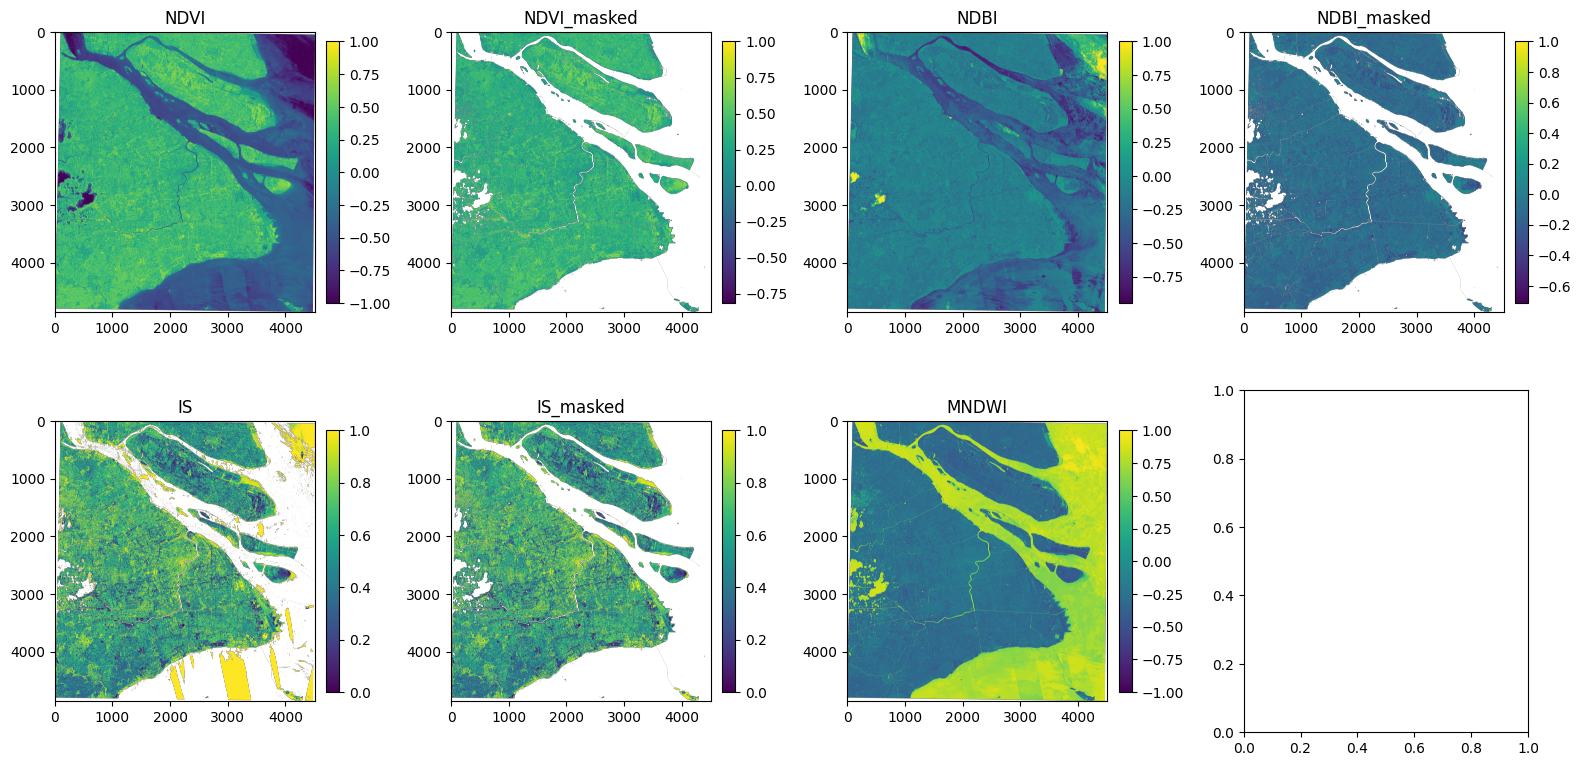

In [ ]:
# Open the file and read all bands
with rasterio.open(filename_a) as src:
    image = src.read(masked=True)   # Read all bands
    band_names = src.descriptions
    n_bands = src.count

print(f"Year: {yr}, # bands: {n_bands}")
print(f"Size: {src.width} x {src.height}, projection: {src.crs}")
print(f"Bands: {band_names}")

# Create figure
n_cols = 4
n_rows = (n_bands + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

# Plot each band
for b in range(n_bands):
    ax = axes[b]
    im = ax.imshow(image[b], cmap='viridis')
    ax.set_title(band_names[b])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
plt.tight_layout()
plt.show()

### Plot specific bands (with custom color bar ranges)

Year: 2024, # bands: 7
Size: 4511 x 4865, projection: EPSG:32651
Bands: ('NDVI', 'NDVI_masked', 'NDBI', 'NDBI_masked', 'IS', 'IS_masked', 'MNDWI')


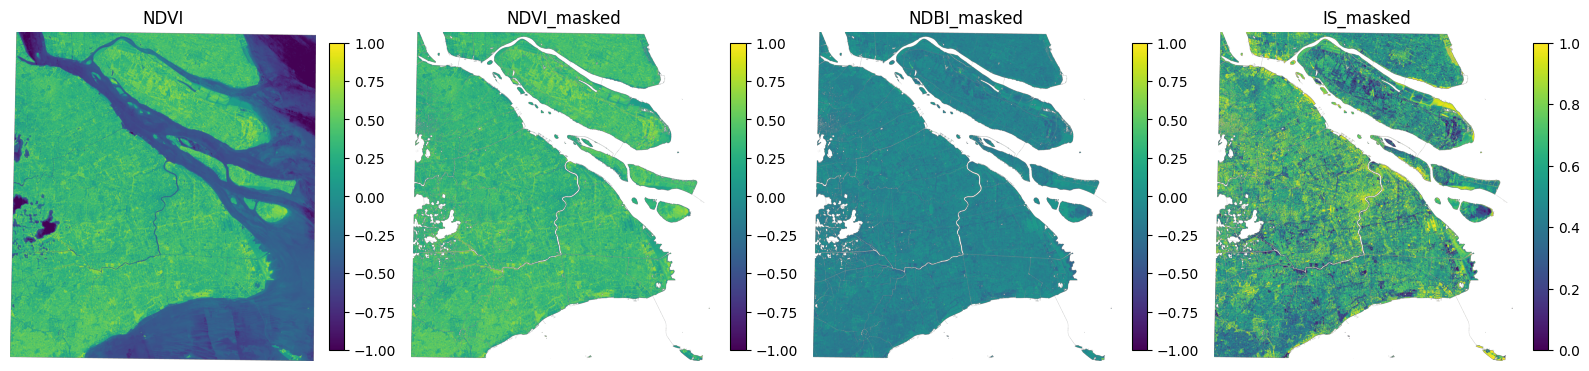

In [ ]:
# Choose what to plot
# names_of_images = ['NDVI', 'NDVI_masked', 'NDBI', 'NDBI_masked', 'IS', 'IS_masked', 'MNDWI']
names_of_images = ['NDVI', 'NDVI_masked', 'NDBI_masked', 'IS_masked']
num_images = len(names_of_images)

# Set value ranges for all indices (to have consistent color scales)
ranges = {
    'NDVI': (-1, 1),    # Range: -1 to 1 (usually vegetation > 0.2, water < 0).
    'NDVI_masked': (-1, 1),    # Range: -1 to 1 (usually vegetation > 0.2, water < 0).
    'NDBI': (-1, 1),    # Range: -1 to 1 (built-up > 0, vegetation negative).
    'NDBI_masked': (-1, 1),    # Range: -1 to 1 (built-up > 0, vegetation negative).
    'IS': (0, 1),   # Range: 0 to 1 (or 0 to 100 if in percentage form).
    'IS_masked': (0, 1),   # Range: 0 to 1 (or 0 to 100 if in percentage form).
    'MNDWI': (-1, 1)   # Range: -1 to 1 (water > 0.2, vegetation < 0).
}

# Open the file and read all bands
with rasterio.open(filename_a) as src:
    band_names = src.descriptions
    n_bands = src.count

    # Create name → index mapping
    band_index = {name: i+1 for i, name in enumerate(band_names)}
    images_to_plot = [src.read(band_index[name]) for name in names_of_images]

print(f"Year: {yr}, # bands: {n_bands}")
print(f"Size: {src.width} x {src.height}, projection: {src.crs}")
print(f"Bands: {band_names}")


# Plot maps of selected indices
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images*4, num_images)) # change figure size as needed

for ax, arr, name in zip(axes, images_to_plot, names_of_images):
    vmin, vmax = ranges[name]
    im = ax.imshow(arr, vmin=vmin, vmax=vmax)
    ax.set_title(name)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()